# Did _Jack Dawson_ die in vain? - Analysing the Titanic dataset for survival

As my question for the dataset, I've chosen a little sidestep of the classic investigation, which is trying to find which variables are likely to predict survival for passengers on the Titanic. Here we go:

---

So, I think many of us watched the movie. :) I did, but it has been a very long time ago. My memory of the actual events portrayed is faded, and I remember being a bit interested, but also a bit dismissive (because probably ashamed) of watching the love story on the big screen. Ah, the teenage years... :)

But one thing that I remember, and that I believe many people were thinking, was that the death of Leonardo Di'Caprio's character _Jack_ seemed a bit unnecessary.

But was it really?
Was it indeed an unnecessary death, or did the end of the movie reflect the actual deaths and survivals on (and off) board of the Titanic well? What does the historical data say?

**Question: For the "Titanic" movie to be historically representative, was the ending appropriate?**

Or more general: What attributes did passengers have, that were likely to survive the sinking of the ship?

---

For this analysis I'll be using the titanic dataset as provided through Udacity in the Data Analyst ND course materials. https://www.udacity.com/course/viewer#!/c-nd002/l-3176718735/m-5420148578, which is identical to the one provided on this kaggle webpage: https://www.kaggle.com/c/titanic/data

Further I'll be brushing up my memories of the movie online from its dedicated wikipedia page: https://en.wikipedia.org/wiki/Titanic_(1997_film) and even it's own whole wiki: http://jamescameronstitanic.wikia.com/wiki/James_Cameron%27s_Titanic_Wiki

And some more general verbose facts from here: http://www.encyclopedia-titanica.org/

---

## 1) Taking a look at the data

In [69]:
import pandas as pd

# reading the csv data into a pandas dataframe
titanic_data_all = pd.read_csv('titanic_data.csv')

titanic_data_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


## 2) Reducing complexity and cleaning the data

### Removing some data

After looking at the printout of the DataFrame containing the available information about the passengers, I decided to remove four of the columns, that I thought would be unlikely to hold predictive value in regards to survival. Those were:

- PassengerId
- Name
- Ticket
- Embarked

In [70]:
titanic_data = titanic_data_all.drop(['PassengerId', 'Name', 'Ticket', 'Embarked'], 1)

In [71]:
print titanic_data.dtypes
titanic_data.head()

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
dtype: object


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,0,3,male,22,1,0,7.2500,NaN
1,1,1,female,38,1,0,71.2833,C85
2,1,3,female,26,0,0,7.9250,NaN
3,1,1,female,35,1,0,53.1000,C123
4,0,3,male,35,0,0,8.0500,NaN


### Survived
1/0 is a boolean construct, so I'll change the data to represent this fact.

In [72]:
titanic_data["Survived"] = titanic_data["Survived"].astype(bool)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,False,3,male,22,1,0,7.2500,NaN
1,True,1,female,38,1,0,71.2833,C85
2,True,3,female,26,0,0,7.9250,NaN
3,True,1,female,35,1,0,53.1000,C123
4,False,3,male,35,0,0,8.0500,NaN


### Pclass
I saw that Pclass is a int64 datatype, however it really represents a categorical set of values. Therefore I will change its dtype to reflect this.

In [73]:
titanic_data["Pclass"] = titanic_data["Pclass"].astype('category')

### Sex
Same goes for Sex. It has the more appropriate "object" dtype, but I will change it to "category".

In [74]:
titanic_data["Sex"] = titanic_data["Sex"].astype('category')

### Cabin

"Cabin" might be an interesting information when assessing why people survived the sinking of the ship. However I could see already in the limited printout, that for many passengers there seems to be no data in regards of the cabin. So I went to check how many have an entry for "Cabin".

In [75]:
cabin_known = titanic_data["Cabin"].notnull().sum()
no_cabin_value = titanic_data["Cabin"].isnull().sum()

print cabin_known, "passengers with cabin data known"
print no_cabin_value, "rows have no data for 'Cabin'"

204 passengers with cabin data known
687 rows have no data for 'Cabin'


I will keep the "Cabin" column around, because it might be interesting. Even though not even quite a quarter of the passengers have specific information in the "Cabin" column, I am not sure whether "NaN" means that they did not stay in a cabin, or whether this data is simply not recorded.

For now I will assume that my dataset is a (more or less) complete record. This would mean that those passengers who do not have a cabin number specified, did actually not stay in a cabin.

---

Next I am wondering how does this relate to Pclass, titled to be a proxy for socio-economic status.

Because it seems also pretty obvious, that _Rose_ (as a first-class passenger) was lodging in a Cabin, while _Jack_ (Pclass = 3) did not have this luxury available. (Even though I did not find this information explicitly in the wiki pages.)

In [76]:
# creating a DataFrame to store this information
cabin_class_1 = titanic_data[titanic_data["Pclass"] == 1]["Cabin"].notnull().sum()
cabin_class_2 = titanic_data[titanic_data["Pclass"] == 2]["Cabin"].notnull().sum()
cabin_class_3 = titanic_data[titanic_data["Pclass"] == 3]["Cabin"].notnull().sum()
nan_class_1 = titanic_data[titanic_data["Pclass"] == 1]["Cabin"].isnull().sum()
nan_class_2 = titanic_data[titanic_data["Pclass"] == 2]["Cabin"].isnull().sum()
nan_class_3 = titanic_data[titanic_data["Pclass"] == 3]["Cabin"].isnull().sum()

class_cabin_dict = {"Cabin known" : pd.Series([cabin_class_1, cabin_class_2, cabin_class_3], index=["Pclass1", "Pclass2", "Pclass3"]),
                   "Cabin NaN" : pd.Series([nan_class_1, nan_class_2, nan_class_3], index=["Pclass1", "Pclass2", "Pclass3"])}
class_cabin_df = pd.DataFrame(class_cabin_dict)
class_cabin_df

,Cabin NaN,Cabin known
Pclass1,40,176
Pclass2,168,16
Pclass3,479,12


Pclass and Cabin seem to be correlated. I think it's time for a graph! :)

Looked for a stacked bar graph to show all Cabin yes vs. all Cabin no, stacked as Classes with color coding!

I decided to use some code to generate stacked bar graphs, which I found online and adapted for my needs.

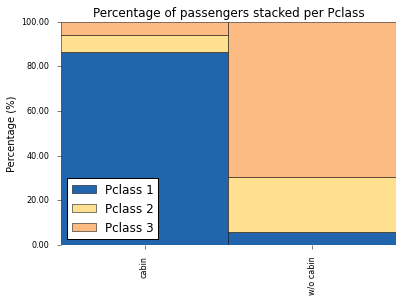

In [77]:
         # courtesy of https://github.com/minillinim/stackedBarGraph GPLv3 - Thanks :)
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import stackedBarGraph as sbg

# creating an instance of the stackedBarGraph class
class_cabin = sbg.StackedBarGrapher()

# convert the data on whether a cabin was booked in relation to the Pclass into a 2 dimensional numpy array
cabin_yes_no = np.array([class_cabin_df["Cabin known"].values,
                        class_cabin_df["Cabin NaN"].values])

# convert np array values to float to work with stackedBarGraph
cabin_yes_no = cabin_yes_no.astype(float)

# setting the values
cabin_yes_no_labels = ["cabin","w/o cabin"]
cabin_yes_no_colors = ['#2166ac', '#fee090', '#fdbb84']

fig = plt.figure()
ax1 = fig.add_subplot(111)
class_cabin.stackedBarPlot(ax1,
                    cabin_yes_no,
                    cabin_yes_no_colors,
                    edgeCols=['#000000']*len(cabin_yes_no[0]),
                    xLabels=cabin_yes_no_labels,
                    ylabel="Percentage (%)",
                    scale=True
                    )
plt.legend(["Pclass 1", "Pclass 2", "Pclass 3"], loc='lower left')
plt.title("Percentage of passengers stacked per Pclass")

From the graph it is apparent (although less surprising), that most passengers for whom a cabin information is recorded were belonging to Pclass 1.
Even though there is absolutely no certainty to this, it might be reasonable to assume that the cabin information was well recorded. This idea comes because it seems valid to assume that most people in Pclass 1 would book a cabin, while most people in Pclass 3 would not do so in order to save on the fare.

Therefore if:
- cabin information was diligently recorded and
- the assumption that Pclass can be seen as a proxy for socioeconomic status is true,

then I think it is valid to say that cabin yes/no can also be seen as a proxy for socioeconomic status.

In [78]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,False,3,male,22,1,0,7.2500,NaN
1,True,1,female,38,1,0,71.2833,C85
2,True,3,female,26,0,0,7.9250,NaN
3,True,1,female,35,1,0,53.1000,C123
4,False,3,male,35,0,0,8.0500,NaN


In [79]:
# reducing the cabin information to boolean values
titanic_data["Cabin"] = titanic_data["Cabin"].notnull()
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,False,3,male,22,1,0,7.2500,False
1,True,1,female,38,1,0,71.2833,True
2,True,3,female,26,0,0,7.9250,False
3,True,1,female,35,1,0,53.1000,True
4,False,3,male,35,0,0,8.0500,False


### SibSp and Parch = Relatives
I will unify the two columns indicating whether the passenger had relatives on board into a single column with boolean values.

Regarding my question about the movie, I'll take a note here that the character _Rose_ had relatives on board (her mother), and the character _Jack_ did not.

In [80]:
# replacing the 0 values for NaN in order to be able to use the notnull() function on these columns
titanic_data["SibSp"] = titanic_data["SibSp"].replace(0, np.nan)
titanic_data["Parch"] = titanic_data["Parch"].replace(0, np.nan)

In [81]:
# the new feature "Relatives" is True when either of the two columns SibSp or Parch has a value
titanic_data["Relatives"] = (titanic_data["SibSp"].notnull()) | (titanic_data["Parch"].notnull())

# removing the two superfluos columns
titanic_data = titanic_data.drop(["SibSp", "Parch"], 1)

titanic_data.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Relatives
0,False,3,male,22,7.2500,False,True
1,True,1,female,38,71.2833,True,True
2,True,3,female,26,7.9250,False,False
3,True,1,female,35,53.1000,True,True
4,False,3,male,35,8.0500,False,False


### Fare
First I will change the values for "Fare" to be integers instead of floats, because these minute differences are very likely not important, and formatted as integers it makes it easier to keep an overview.

In [82]:
titanic_data["Fare"] = titanic_data["Fare"].astype('int64')

print titanic_data.dtypes
titanic_data.head()

Survived         bool
Pclass       category
Sex          category
Age           float64
Fare            int64
Cabin            bool
Relatives        bool
dtype: object


,Survived,Pclass,Sex,Age,Fare,Cabin,Relatives
0,False,3,male,22,7,False,True
1,True,1,female,38,71,True,True
2,True,3,female,26,7,False,False
3,True,1,female,35,53,True,True
4,False,3,male,35,8,False,False


## 3) Investigating the single variables
Before thinking about how the different features relate to each other, I will take a short look at the single variables.

For this, I will write a multi-purpose-function.

In [152]:
def stats_and_plot(dataset, column_header):
    '''Calculates basic statistical values and a bar plot or histogram for one column.
    
    takes as input the name of a column in the titanic_data
    depending on whether the column holds quantitative or categorical data:
    - display appropriate statistical values for the column
    - constructs a histogram or a bar chart
    '''
    quantitative_data = ["float64", "int64"]
    categorical_data = ["category", "object", "bool"]
    
    print dataset[column_header].describe()
    if dataset[column_header].dtype.name in quantitative_data:
        print "median   ", dataset[column_header].median()
    
    %matplotlib inline
    import numpy as np
    import matplotlib.pyplot as plt

    data_no_nan = np.array(dataset[column_header].dropna())
    if dataset[column_header].dtype.name in quantitative_data:
        # getting the min and max for the axis
        min_val = dataset[column_header].min()
        max_val = dataset[column_header].max()
        # getting an appropriate bin size
        val_range = max_val - min_val
        bins = int(val_range / 10)
        # constructing the histogram
        plt.hist(data_no_nan)
        plt.xlabel(column_header)
        plt.ylabel("amount of passengers")
        plt.title("single-variable analysis for " + column_header)
        plt.axis([min_val, max_val, 0, 100])
        plt.grid(True)
    elif dataset[column_header].dtype.name in categorical_data:
        # bins should be the amount of categorical values present, if categorical
        # constructing the bar plot
        dataset[column_header].value_counts().plot(kind="bar")
        plt.xlabel(column_header)
        plt.ylabel("amount of passengers")
        plt.title("single-variable analysis for " + column_header)
        #plt.axis([min_val, max_val, 0, 100])
        plt.grid(True)

count          891
mean     0.3838384
std      0.4865925
min          False
25%              0
50%              0
75%              1
max           True
Name: Survived, dtype: object


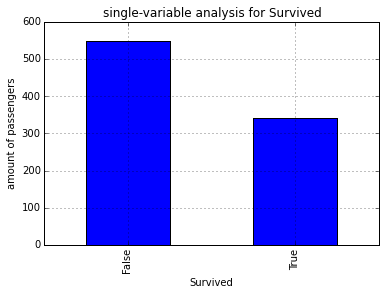

In [153]:
stats_and_plot(titanic_data, "Survived")

More people died than survived. Ah...

count     891
unique      3
top         3
freq      491
Name: Pclass, dtype: int64


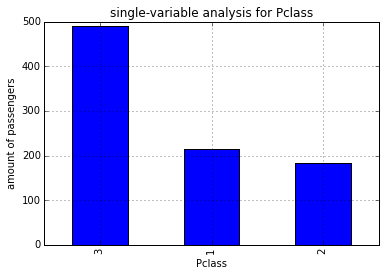

In [154]:
stats_and_plot(titanic_data, "Pclass")

Most people on the ship were poor.

count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object


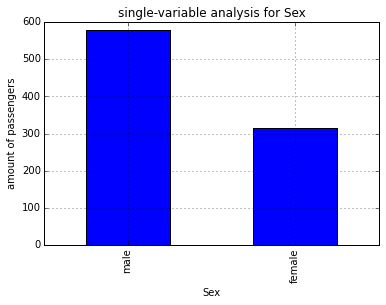

In [155]:
stats_and_plot(titanic_data, "Sex")

There were significantly more Males than Females on the ship.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
median    28.0


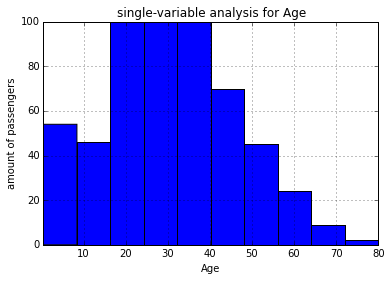

In [156]:
stats_and_plot(titanic_data, "Age")

There were quite some children, but the majority of the travellers were in mid-age (20-40).

count    891.000000
mean      31.785634
std       49.703730
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64
median    14.0


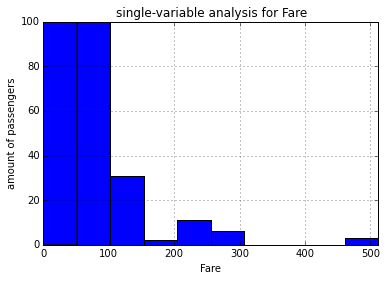

In [157]:
stats_and_plot(titanic_data, "Fare")

Most tickets purchased were in the lower price range, there are some more expensive ones and a very high-up outlier.

count          891
mean     0.2289562
std       0.420397
min          False
25%              0
50%              0
75%              0
max           True
Name: Cabin, dtype: object


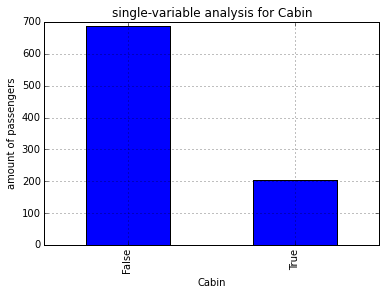

In [158]:
stats_and_plot(titanic_data, "Cabin")

For most passengers, there is no Cabin information recorded, maybe most didn't lodge in a Cabin.

count          891
mean     0.3973064
std      0.4896152
min          False
25%              0
50%              0
75%              1
max           True
Name: Relatives, dtype: object


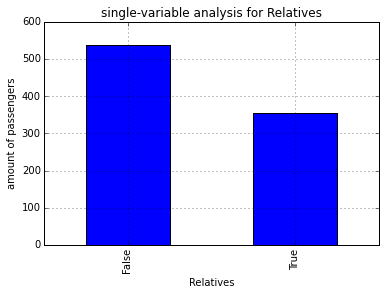

In [159]:
stats_and_plot(titanic_data, "Relatives")

And... more people were travelling alone.

## 4) Time for looking for relationships in the data
Now I will check how the cleaned data relates to each other, and whether I can discover patterns that could lead to good predictions on survival of the passengers in general.

Also, these investigation should bring me closer to answering the question about how historically representative is the death of _Jack Dawson_ at the end of the "Titanic" movie.

Since my basic distinction is gonna be whether someone survived or not, I'll split the data according to "Survived".

In [160]:
titanic_survivors = titanic_data[titanic_data["Survived"] == True]
titanic_non_survivors = titanic_data[titanic_data["Survived"] == False]

### Fare

According to the wikipedia page, _Jack Dawson_ won his ticket for the Titanic at a card game, therefore it is impossible to determine how much his ticket was actually worth. However, from the lower-class setting where this game took place, and the space he receives when boarding the ship (Pclass 3), it is reasonable to assume that the price of the ticket might have ranged below the median.

_Rose_'s ticket, on the other hand, was one from Pclass 1, therefore it probably cost more than the median Fare.

In [161]:
titanic_data["Fare"].median()

14.0

In [162]:
titanic_data["Fare"].describe()

count    891.000000
mean      31.785634
std       49.703730
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64

The minimum is 0, so I am wondering whether informationis missing for Fare, or whether it is recorded that some passenger(s) actually paid 0$.

In [163]:
# for how many passengers is no Fare information recorded
amount_missing_fares = titanic_data["Fare"].isnull().sum()
# how many passengers paid 0
amount_zero_fares = len(titanic_data[titanic_data["Fare"] == 0]["Fare"])
        
print "NaN in Fare:", amount_missing_fares
print "0 in Fare:", amount_zero_fares

NaN in Fare: 0
0 in Fare: 15


Now that I know that there should be 15 passengers who paid a 0$ Fare, I'll take a look at the relevant rows!

In [164]:
free_riders = titanic_data[titanic_data["Fare"] == 0]
# investigate numerical and boolean values
free_riders.describe()

,Survived,Age,Fare,Cabin,Relatives
count,15,7.000000,15,15,15
mean,0.06666667,35.142857,0,0.2,0
std,0.2581989,10.023781,0,0.4140393,0
min,False,19.000000,0,False,False
25%,0,30.500000,0,0,0
50%,0,38.000000,0,0,0
75%,0,39.500000,0,0,0
max,True,49.000000,0,True,False


In [165]:
# investigate categorical values
free_riders["Sex"].describe()

count       15
unique       1
top       male
freq        15
Name: Sex, dtype: object

#### Looking at the free-riders
I know that _Jack_ cannot be legitimately counted to those paying 0$, even though he did in fact not pay for his Fare. But the person he won the tickets from did.

However, I took this example to practice **making subsets of a dataframe**.

What I got to see in this small subset of the 15 passengers that paid 0 for their Fare, is:

- all were male
- none had relatives on board
- most lodged in a cabin
- and nearly all of them died

(The other values for Age and Pclass seem to be more diverse)

Therefore I would say that skipping the Fare is not a good way to survive the catastrophe... :)

_**Disclaimer**: I understand that this is not a useful conclusion, especially because the dataset is very very small_

### Age in comparison
Having my two datasets, split on the independent variable, I'll start to compute statistical values for them

In [166]:
print "SURVIVORS \n", titanic_survivors["Age"].describe()
print "\n"
print "NON-SURVIVORS \n", titanic_non_survivors["Age"].describe()

SURVIVORS 
count    290.000000
mean      28.343690
std       14.950952
min        0.420000
25%       19.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64


NON-SURVIVORS 
count    424.000000
mean      30.626179
std       14.172110
min        1.000000
25%       21.000000
50%       28.000000
75%       39.000000
max       74.000000
Name: Age, dtype: float64


On first sight, this doesn't look too interesting. There is a very minimal hint that Survivors might be altogether younger, but the difference is small. I will now look at the variables from aspect fo the split datasets.

count    290.000000
mean      28.343690
std       14.950952
min        0.420000
25%       19.000000
50%       28.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64
median    28.0


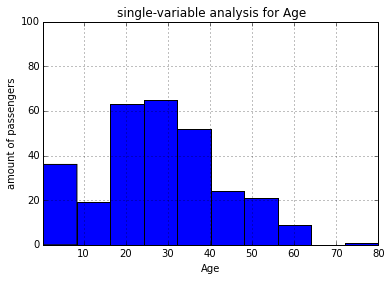

In [167]:
stats_and_plot(titanic_survivors, "Age")

count    424.000000
mean      30.626179
std       14.172110
min        1.000000
25%       21.000000
50%       28.000000
75%       39.000000
max       74.000000
Name: Age, dtype: float64
median    28.0


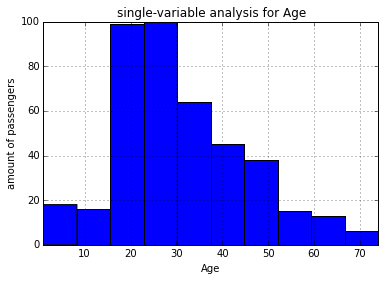

In [168]:
stats_and_plot(titanic_non_survivors, "Age")

Here it becomes very obvious that way more passengers in mid-age died than those younger.

#### Age and its difficulties

According to the "Titanic" movie websites, _Rose_ was feeling depressed about being constantly not taken seriously and treated like a child. Legally, with the age of 17, she might have been what was considered a _young person_ (the equivalent of today's _teenager_).
Source: http://www.encyclopedia-titanica.org/forums/politics-laws/4620-age-majority.html

The age limit for **children** might have been more correctly considered to be around 12-13, while the age of majority might have been still 21. However, as the thread discusses, young people were most likely treated as adults many years earlier (maybe the plights came, but not yet the rights?).

Well, the actual age border seems to have been not too clear, and especially in the situation of a sinking ship, I can imagine that there were many unclarities and fast decisions for _children_ and _young people_ aged between 12 and 18.

At first I will try to take the age as border, that more or less put an end to one being considered a **child**.

In [98]:
child_age = 13

children_survived = len(titanic_survivors[titanic_survivors["Age"] <= child_age]["Age"])
children_died = len(titanic_non_survivors[titanic_non_survivors["Age"] <= child_age]["Age"])

print "surviving children:", children_survived
print "non-surviving children:", children_died

surviving children: 42
non-surviving children: 29


I can see that more children survived than died.

Now I want to take a look at the figures if I include also _young people_.

Because legally (even though she might object), _Rose_ would have actually most likely not been counted among the adults.

In [99]:
young_age = 18

minors_survived = len(titanic_survivors[titanic_survivors["Age"] <= young_age]["Age"])
minors_died = len(titanic_non_survivors[titanic_non_survivors["Age"] <= young_age]["Age"])

print "surviving minors:", minors_survived
print "non-surviving minors:", minors_died

surviving minors: 70
non-surviving minors: 69


Okay, on first sight these above results don't seem too spectacular. It seems that as a _young person_ on the Titanic (at least according to the sub-set of the data that I am analysing), you had a near-perfect 1 in 2 chance of surviving the disaster. _Life or death, at the flip of a coin._

So, did _Rose_ just got lucky?

One thing to make clear here is, that a 50% chance of survival can still be much higher than many other percentile rates of survival!

So let's look at this for the **"adults"**. 

In [100]:
def amount_of_passengers(data_table, column_header, operator, value):
    ''' Computes the amount of passengers for a given setting.
    
    takes as input a pandas dataframe, the name of the column that is being queried,
    an operator ["smaller", "smaller_eguals", "bigger", "bigger_equals"] and the value of the query parameter.
    returns the number of passengers in the dataframe that fits the defined query
    '''
    if operator == "smaller":
        num_passengers = len(data_table[data_table[column_header] < value][column_header])
    elif operator == "smaller_equals":
        num_passengers = len(data_table[data_table[column_header] <= value][column_header])
    elif operator == "bigger":
        num_passengers = len(data_table[data_table[column_header] > value][column_header])
    elif operator == "bigger_equals":
        num_passengers = len(data_table[data_table[column_header] >= value][column_header])
    else:
        print 'Error. Please enter a valid operator from the list:'
        print '["smaller", "smaller_eguals", "bigger", "bigger_equals"]'
        return
    return num_passengers

In [101]:
age_of_majority = 21

adults_survived = amount_of_passengers(titanic_survivors, "Age", "bigger_equals", age_of_majority)
adults_died = amount_of_passengers(titanic_non_survivors, "Age", "bigger_equals", age_of_majority)

print "adults survived:", adults_survived
print "adults died: ", adults_died

adults survived: 208
adults died:  326


Since I am investigating for the survival of _Rose_ and _Jack_, I'll also look at the values when drawing the line at 18, a currently popular age of majority, that might have also had some practical application then.

Drawind this line there will leave where our fictional character _Rose_ on one side, and _Jack_, with the tender age of 20, would be on the other side. A tragic image for the young lovers, this is certain!

In [102]:
grown_age = 18

grown_survived = amount_of_passengers(titanic_survivors, "Age", "bigger", grown_age)
grown_died = amount_of_passengers(titanic_non_survivors, "Age", "bigger", grown_age)

print "adults survived:", grown_survived
print "adults died: ", grown_died

adults survived: 220
adults died:  355


I am aware that this decision is not necessarily grounded on well-supported data, however for the sake of my investigation (and simplicity) I will keep the "Age" border, where I distinguish between _young people_ and _adults_, at the age of 18.

Next I will compare the ratios for the two groups.

In [103]:
minors_ratio = minors_survived / float(minors_died)
adult_ratio = adults_survived / float(adults_died)

ratios = pd.Series([minors_ratio, adult_ratio], ["Survival of young people", "Survival of adults"],
                   name="ratios of survival")
print ratios

Survival of young people    1.014493
Survival of adults          0.638037
Name: ratios of survival, dtype: float64


In [104]:
def survival_by_value(column_header, value):
    ''' Calculates the ratios of survivors and non-survivors for a given column, split by a given value.
    
    takes as input a column header and a corresponding value for a query.
    returns a pandas Series object holding the ratios of survivors compared to non-survivors
    for the rows below and including the defined value in the given column
    and the rows above the defined value in the given column
    '''
    survived_below = amount_of_passengers(titanic_survivors, column_header, "smaller_equals", value)
    died_below = amount_of_passengers(titanic_non_survivors, column_header, "smaller_equals", value)
    survived_above = amount_of_passengers(titanic_survivors, column_header, "bigger", value)
    died_above = amount_of_passengers(titanic_non_survivors, column_header, "bigger", value)
    below_ratio = survived_below / float(died_below)
    above_ratio = survived_above / float(died_above)
    ratios = pd.Series([below_ratio, above_ratio], ["Survival of those BELOW (and including) entered value", 
                                                    "Survival of those ABOVE entered value"], 
                       name="Ratios for %s, split at %s" %(column_header, value))
    return ratios

print "STATISTICAL VALUES FOR Age"
print titanic_data["Age"].describe(), "\n"
print survival_by_value("Age", grown_age)

STATISTICAL VALUES FOR Age
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64 

Survival of those BELOW (and including) entered value    1.014493
Survival of those ABOVE entered value                    0.619718
Name: Ratios for Age, split at 18, dtype: float64


So the chances of survival were indeed much higher for children than for adults! 

_Rose_ might not have liked to be treated as a child while all was going well on the ship. However, when the disaster struck, she would be better off when holding back her teenage upwellings of self-responsibility.

---

I took a peek into this data already further up, but I chose to dig a little deeper, trying to explore and account for some inaccuracies and definition problems regarding who would be considered a _child_ in "_Women and children first_".

Let's see how the rate of survival was spread among the Age of the passengers.
I'll look at it visualized with a Histogram. First I look at the min and max values, then at the range

In [169]:
min_age = titanic_data["Age"].min()
max_age = titanic_data["Age"].max()

age_range = max_age - min_age
print "Range of 'Age':", age_range

Range of 'Age': 79.58


According to this range I will choose a bin size of 10, resulting in 8 bins.

In [170]:
bins = 8
print "Chosen amount of bins:", bins

Chosen amount of bins: 8


Here I'll look at this with a histogram representing the continuous value of "Age" on one axis, and the amount of passengers who survived on the other axis.

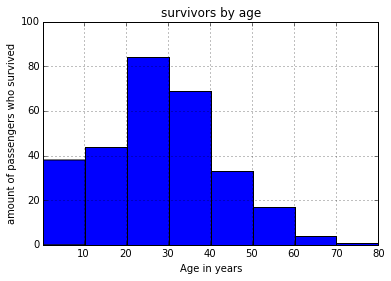

In [171]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

surv_age_no_nan = titanic_survivors["Age"].dropna()
surv_array = surv_age_no_nan.as_matrix()

plt.hist(surv_array, bins)
plt.xlabel("Age in years")
plt.ylabel("amount of passengers who survived")
plt.title("survivors by age")
plt.axis([min_age, max_age, 0, 100])
plt.grid(True)

Looking at the same graph for those who didn't survive:

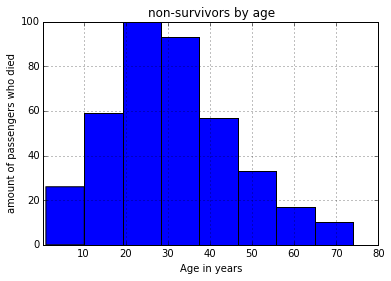

In [172]:
no_surv_age_no_nan = titanic_non_survivors["Age"].dropna()
no_surv_array = no_surv_age_no_nan.as_matrix()

plt.hist(no_surv_array, bins)
plt.xlabel("Age in years")
plt.ylabel("amount of passengers who died")
plt.title("non-survivors by age")
plt.axis([min_age, max_age, 0, 100])
plt.grid(True)

Because I want to compare this data, I will plot them together onto one graph.

In [200]:
plot_surv = titanic_survivors["Age"]
plot_non_surv = titanic_non_survivors["Age"]

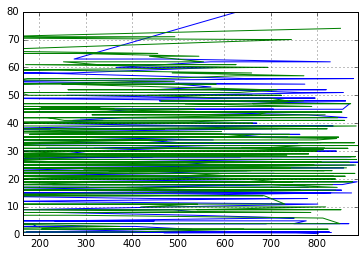

In [186]:
sorted_surv = titanic_survivors.sort(columns="Age", ascending=True)
sorted_non_surv = titanic_non_survivors.sort(columns="Age", ascending=True)
sorted_surv["Age"].plot()
sorted_non_surv["Age"].plot()

One striking difference when looking at these two graphs, is the first bin (0-10 years of age). It is right away clear that there are way more passengers that fit into this bin in the list of the survivors, than there are in the list of the non-survivors.

The rest of the histogram seems to take a similar shape, only that the non-survivors hold higher absoulte amounts, because more people died than survived the disaster altogether.

However, the first bin defies this general trend and actually holds a lower absolute amount of passengers for the non-survivors than for the survivors, indicating also here, that there was a selection towards allowing children to enter the life boats at a higher rate than other passengers.

Regarding my analysis of the movie, the bin sizes chosen are not optimum, since I have further up decided the break between "child" and "adult" at up to and including 18. This also separates _Rose_, who is 17, from _Jack_, who is 20 at the time of the sinking of the ship.

Therefore it might be worth to look at the histogram with a changed bin size.

So I will look for a better fitting bin size, that emphasizes the split between "child" and "adult" (as defined above).

I want to take into account, that teenagers might have still been treated differently than very small children. So I would want to have at least two bins for those in the category "child"

In [115]:
child_age = 18

bins = age_range / (child_age / 2)
bins = bins.round()

Here come the histograms again with the new bin size of 9, resulting in 9 bins.

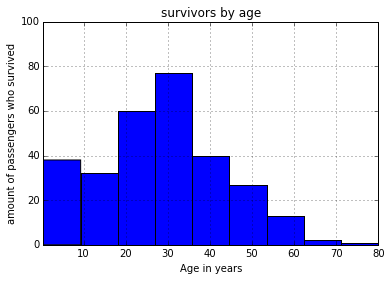

In [118]:
surv_age_no_nan = titanic_survivors["Age"].dropna()
surv_array = surv_age_no_nan.as_matrix()

plt.hist(surv_array, bins)
plt.xlabel("Age in years")
plt.ylabel("amount of passengers who survived")
plt.title("survivors by age")
plt.axis([min_age, max_age, 0, 100])
plt.grid(True)

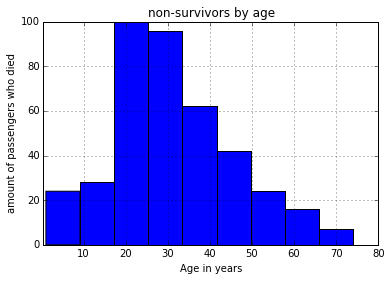

In [119]:
no_surv_age_no_nan = titanic_non_survivors["Age"].dropna()
no_surv_array = no_surv_age_no_nan.as_matrix()

plt.hist(no_surv_array, bins)
plt.xlabel("Age in years")
plt.ylabel("amount of passengers who died")
plt.title("non-survivors by age")
plt.axis([min_age, max_age, 0, 100])
plt.grid(True)

We can see that there is a change in the general trend, that offers a new perspective that might have been obfuscated with the previous bin size setting:

By far the highest amount of casualties falls within the 3rd bin (Age: 19-24). In the previous two graphs, the number of non-survivors was much higher for the 2nd bin, because it also included those aged 19 and 20 (the range set was 10-20). These people were, however, practically already considered "adults" and therefore probably did not come into the benefits of _Women and children first!_.

I believe that the second pair of graphs represents the actual situation better, and that for this analysis the bin size of 9 is more appropriate than the bin size of 10.

There is still a marked difference in the amounts of survivors for both first bins as compared to the first two bins of the non-survivors.
While in all other bins the absolute number of passengers is higher for the non-survivors, the numbers are inverse for these bins holding the "children" (as defined above).

_Rose_ should consider herself lucky to be counted among the children, and maybe she would change her mind about the advantages of being grown up, when seeing these numbers. :)
But then, this is not how the heads of teenagers function!

### Fare - do the spendatious live longer?


Let's think about the money spent for the ticket. I've already done some cleaning and analysis above, and mentioned that there was most likely a marked difference between the actual worth of _Jack_'s and _Rose_'s tickets.

But did paying more actually help you to survive the sinking of the ship? Let's take a look. (I'll repeat my single-variable analysis here).

count    891.000000
mean      31.785634
std       49.703730
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64
median    14.0


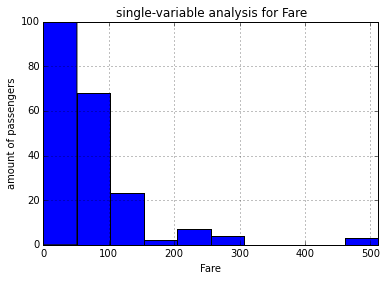

In [121]:
stats_and_plot(titanic_data, "Fare")

The maximum seems to be quite an outlier, so I did not trust the average as a useful value.
I'll choose up to and including the median as a low fare, and what is above the median as a high fare.

In [122]:
import numpy as np

median_fare = np.median(titanic_data["Fare"])
survivors_rich = amount_of_passengers(titanic_survivors, "Fare", "bigger", median_fare)
survivors_poor = amount_of_passengers(titanic_non_survivors, "Fare", "bigger", median_fare)

In [123]:
survival_by_value("Fare", median_fare)

Survival of those BELOW (and including) entered value    0.332362
Survival of those ABOVE entered value                    1.106796
Name: Ratios for Fare, split at 14.0, dtype: float64

This looks promising! Seems one can indeed buy oneself the way out of disaster...

### Three (Pseudo-)Boolean values
Cabin, Relatives, Sex are all categorical values (and can even be considered boolean values).
Here I'll write functions to handle these.

In [135]:
def amount_of_passengers_bool(column_header, one_value):
    '''Calculates the amounts of passengers for both boolean values in the survivor and non-survivor dataset.
    
    takes as input the header of a column and one of the two boolean values
    (this is, so that the function also accounts for pseudo-boolean constructs)
    returns a list of amounts of passengers that includes the following:
    [survivors_fitting_the_entered_query_value, survivors_NOT_fitting_the_entered_query_value,
    NON_survivors_fitting_the_entered_query_value, NON_survivors_NOT_fitting_the_entered_query_value]
    '''
    survivors_1 = len(titanic_survivors[titanic_survivors[column_header] == one_value])
    survivors_2 = len(titanic_survivors[titanic_survivors[column_header] != one_value])
    non_survivors_1 = len(titanic_non_survivors[titanic_non_survivors[column_header] == one_value])
    non_survivors_2 = len(titanic_non_survivors[titanic_non_survivors[column_header] != one_value])
    amount_list = [survivors_1, survivors_2, non_survivors_1, non_survivors_2]
    return amount_list
            
def survival_by_bool_value(column_header, one_value):
    ''' Calculates the ratios of survival for a column with boolean values.
    
    takes as input the header of a column and one of the two boolean values
    (this is, so that the function also accounts for pseudo-boolean constructs)
    returns a pandas Series object containing the two ratios
    '''
    amount_list = amount_of_passengers_bool(column_header, one_value)
    survived_provided_value = amount_list[0]
    died_provided_value = amount_list[2]
    survived_other_value = amount_list[1]
    died_other_value = amount_list[3]
    provided_value_ratio = survived_provided_value / float(died_provided_value)
    other_value_ratio = survived_other_value / float(died_other_value)
    ratios = pd.Series([provided_value_ratio, other_value_ratio], ["Survival of %s (entered value)" %(one_value), 
                                                                   "Survival of second value (not entered)"],
                      name="ratios of survival according to %s" %(column_header))
    return ratios

print "RATIOS OF SURVIVAL ACCORDING TO Sex (female/male):"
print survival_by_bool_value("Sex", "female"), "\n"
print "RATIOS OF SURVIVAL ACCORDING TO Cabin (True/False):"
print survival_by_bool_value("Cabin", True), "\n"
print "RATIOS OF SURVIVAL ACCORDING TO Relatives (True/False):"
print survival_by_bool_value("Relatives", True)

RATIOS OF SURVIVAL ACCORDING TO Sex (female/male):
Survival of female (entered value)        2.876543
Survival of second value (not entered)    0.232906
Name: ratios of survival according to Sex, dtype: float64 

RATIOS OF SURVIVAL ACCORDING TO Cabin (True/False):
Survival of True (entered value)          2.000000
Survival of second value (not entered)    0.428274
Name: ratios of survival according to Cabin, dtype: float64 

RATIOS OF SURVIVAL ACCORDING TO Relatives (True/False):
Survival of True (entered value)          1.022857
Survival of second value (not entered)    0.435829
Name: ratios of survival according to Relatives, dtype: float64


The results indicate that it was more likely for a passenger to survive if:

- the passenger was **female**
- did have a **cabin**
- and **had relatives** on board

_Rose_ has a bright outlook, also according to these results, while _Jack_'s future seems to gloomily foreshadow the events of the end of the movie.

Earlier I discovered, that passengers with Cabin are likely to be of Pclass 1, drawing a connection between socio-economic status and Cabin. That the wealthier were treated with precedence seems to also holds true from this aspect, after comparing how lodging in a Cabin relates to survival.

I will now take a more direct look at this prediction.

### Social Class and Survival
The final value to investigate is Pclass, a collection of ordinal values [1, 2, 3], that are meant to be an indicator for socio-economic status.

Since it's a bit a different type of data, I first thought I'll have to make a new function for this cause.
BUT, since I'm only trying to get the difference between Pclass 1 and (Pclass 2 AND Pclass 3), it's again a pseudo-boolean, so I can use my function that I just wrote above (its "!=" statement will catch both Pclass 2 and Pclass 3 entries).

In [138]:
survival_by_bool_value("Pclass", 1)

Survival of 1 (entered value)             1.700000
Survival of second value (not entered)    0.439232
Name: ratios of survival according to Pclass, dtype: float64

_a bit lazy, I agree. :)_
    
But we can see that being part of Pclass 1 was a great advantage for the passengers and significantly increased their rate of survival.

This is something that I expected, knowing society a little bit, and what was also foreshadowed through the results for "Cabin". Usually people of higher status are also treated more favourably. They are also likely to have had more money, and might have just bought their place on a lifeboat.

Again, this result speaks in favour of _Rose_ surviving and _Jack_ perishing in the Titanic disaster, supporting the historical representativeness of the movie.

## 5) Discussion

So here I will try to write a sum up of my analysis.
The following values are those that are likely to be useful variables to predict survival of the passengers:

- Pclass = 1
- Sex = female
- Fare > 14
- Age <= 18
- Cabin = True
- Relatives = 1

meaning that a passenger that fulfills some of these criteria is more likely to have survived.
The more, the higher is the chance of survival.

We can already see here, that the character _Rose_ scores well on all criteria, while the inverse is true for the character _Jack_.

---

Some attributes, however, are more important than others. Let's talk more about this.

For this I'll create a dataframe holding all the ratios of these (hopefully) predictive values as compared to their pseudo-boolean opposites.

In [146]:
# first I'll need a dataframe
ratios_df = pd.DataFrame(index=["var_indicates_survival", "var_means_probably_not"])

# then I need a function
def add_ratio_to_df(column_name, survival_predictor_value):
    '''Appends the ratios for a predictor value regarding survival to a dataframe.
    
    calculates the ratios for survivors vs. non-survivors for one criteria (column_name).
    then it creates a new column in ratios_df and puts the two calculated ratios there,
    assigning the higher one to the 0th row, the lower one to the 1st row.
    '''
    if column_name == "Sex" or column_name == "Cabin" or column_name == "Relatives" or column_name == "Pclass":
        ratios = survival_by_bool_value(column_name, survival_predictor_value)
        ratios_df.loc[:, column_name] = pd.Series([ratios[np.argmax(ratios)], ratios[np.argmin(ratios)]], index = ratios_df.index)
    elif column_name == "Fare" or column_name == "Age":
        ratios = survival_by_value(column_name, survival_predictor_value)
        ratios_df.loc[:, column_name] = pd.Series([ratios[np.argmax(ratios)], ratios[np.argmin(ratios)]], index = ratios_df.index)
        
# and now I'll call them all!
add_ratio_to_df("Cabin", False)
add_ratio_to_df("Sex", "female")
add_ratio_to_df("Relatives", 1)
add_ratio_to_df("Pclass", 1)
add_ratio_to_df("Age", 18)
add_ratio_to_df("Fare", 14)

# and this is how it looks like
ratios_df

,Cabin,Sex,Relatives,Pclass,Age,Fare
var_indicates_survival,2.000000,2.876543,1.022857,1.700000,1.014493,1.106796
var_means_probably_not,0.428274,0.232906,0.435829,0.439232,0.619718,0.332362


In [147]:
# calculating the difference between survival and death
difference = ratios_df.diff().iloc[1]

In [149]:
# ordering the Series object to display the one with the highest difference on top, then descending.
ordered_differences = difference.order()
# changing the name of the Series object
ordered_differences = pd.Series(ordered_differences.values, ordered_differences.index, 
                                name="predictor variables by significance")
ordered_differences

Sex         -2.643637
Cabin       -1.571726
Pclass      -1.260768
Fare        -0.774435
Relatives   -0.587028
Age         -0.394774
Name: predictor variables by significance, dtype: float64

---

Yay! So here we go. Now I finally know what attributes to a passenger make it possible to predict with high(er) accuracy whether they managed to survive the Titanic ship-sinking-destruction-disaster, or whether they perished into fishfood.

The pandas Series object `ordered_differences` above is a list of the useful variables for this, ordered according to importance.

This means for example, that if taking into account only a single variable, knowing the Sex of a passenger will be the safest way to guess whether they survived or not.
Then follows whether they had a cabin or not.
etc.

### Answering my question

So, according to my analysis, the movie could indeed be considered historically representative:

- **_Rose_**, the relatively rich Pclass 1 female Age=17 lodging in a Cabin with Relatives on board, **survived**
- while **_Jack_**, the Pclass 3 male, who (most likely) had a cheap ticket, no Cabin, and was older than 18, **perished**

---

One thing that became clear to me while looking at the titanic dataset, and reading about James Cameron's work when creating the "Titanic" movie, was that there was a lot of effort taken to incorporate the actual historical events into the film.

Reading about Cameron's excitement about sunken ships and the dives they did to look at and film the actual wreck of the Titanic, was impressive to me, and allowed me to get a new impression of the movie that I had watched as a teenager. The scientific approach that seems to have gone into gathering information about the historical events on the Titanic made me pull my imaginary hat in front of the director, and revisit my criticism of the final death of _Jack_.

In my research I also found an Episode of Mythbusters, that claim to have found a way in which _Jack_ could have made his way onto the floating board and survived: http://www.discovery.com/tv-shows/mythbusters/videos/rocket-surfer-aftershow/
But I must say I find the reasoning not very impressive, considering that it involved a lot of dipping into the icy water and an idea that one does not necessarily come up with when faced with such a life-threatening situation.
There is also a smugness of delivering this medium-amazing discovery to the director, that I don't think is appropriate.

What I instead take from this video is, that during their first tries, the raft seemed to not hold two people, and without the life jacket trick, it wouldn't have.
Therefore I again salute to James Cameron's sense of accuracy, and conclude that the audience's infuriation with the question why _Jack_ did not simply climb onto the raft himself too, comes from a general ignorance of not knowing how unstable such a floating piece of door actually is (and probably also the wish for the love story to have a happy ending :).

Add some ice to this, a dramatic sinking with thousands dying and love troubles on your mind, plus considering the results of my analysis that gave _Jack_ a bad set of cards regarding his survival right from the start, and finally also the questions of etiquette that took the lives of many men aboard at that time (there would have been a deadly public shame associated with having survived the disaster while women and children that _could have survived_ did not), and I am personally easily convinced that it is a realistic outcome that _Jack_ he would have frozen to his honorable death.

I therefore mark my teenage rambling and smugness about his "unnecessary" death into the area of ignorance, and bid my respect towards James Cameron's impressive research and attempts to create a realistic fictional story, set on the background of a historical disaster.